# Employee Burnout Prediction (Business-Centric analysis)
 
**Goal:** Predict employee burnout risk based on wellness indicators such as  
work hours, sleep hours, stress level, job satisfaction, and manager support.

**Tools Used:**
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")


## 1. Project Setup

We define project folder paths to load raw data, save visuals, and export processed datasets.


In [2]:
PROJECT_ROOT = os.path.dirname(os.getcwd())

RAW_DATA_DIR = os.path.join(PROJECT_ROOT, "Raw Data")
PROCESSED_DATA_DIR = os.path.join(PROJECT_ROOT, "data_processed")
VISUALS_DIR = os.path.join(PROJECT_ROOT, "visuals")

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)

print("Project Root:", PROJECT_ROOT)

Project Root: C:\py_code\Employee


## 2. Load Dataset

Load cleaned employee wellness dataset.


In [3]:
CSV_PATH = os.path.join(PROJECT_ROOT, "Raw Data", "employee_wellness_clean.csv")
wellness_df = pd.read_csv(CSV_PATH)

## 3. Basic Data Understanding

Check first few rows, dataset structure, and statistical summary.


In [4]:
print("\nFirst 5 rows:")
display(wellness_df.head())

print("\nDataset Info:")
print(wellness_df.info())

print("\nSummary Statistics:")
display(wellness_df.describe())



First 5 rows:


id first_name last_name   birthdate  gender               race  \
0  EMP-10000     Sophia    Taylor         NaN  Female              White   
1  EMP-10001       Emma   Johnson         NaN  Female  Two or More Races   
2  EMP-10002      Ethan     Brown         NaN  Female              Asian   
3  EMP-10003     Olivia    Sharma         NaN    Male              White   
4  EMP-10004     Sophia     Smith  1999-12-31    Male              Asian   

   department     jobtitle       location   hire_date  ... location_city  \
0          HR      Manager         Remote         NaN  ...         Flint   
1       Sales     Engineer  Branch Office         NaN  ...        Austin   
2   Marketing   Specialist   Headquarters         NaN  ...        Albany   
3     Product  Coordinator  Branch Office  2008-10-26  ...      San Jose   
4  Operations  Coordinator         Remote  2009-04-13  ...      San Jose   

  location_state remote_work work_hours  sleep_hours  stress_level  \
0     California         Yes       8.54         8.42           3.0   
1           Ohio          No       8.67         7.60           4.0   
2       New York          No      10.76         6.78           7.0   
3           Ohio          No       9.18         7.40           5.0   
4          Texas         Yes       8.25         7.33           4.0   

   job_satisfaction  manager_support  burnout_risk productivity_score  
0               8.0              3.0           Low               80.0  
1               6.0              4.0           Low               67.0  
2               4.0              6.0        Medium               48.0  
3               6.0              7.0           Low               61.0  
4               6.0              9.0           Low               60.0  

[5 rows x 21 columns]


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5000 non-null   object 
 1   first_name          5000 non-null   object 
 2   last_name           5000 non-null   object 
 3   birthdate           1611 non-null   object 
 4   gender              5000 non-null   object 
 5   race                5000 non-null   object 
 6   department          5000 non-null   object 
 7   jobtitle            5000 non-null   object 
 8   location            5000 non-null   object 
 9   hire_date           1590 non-null   object 
 10  termdate            562 non-null    object 
 11  location_city       5000 non-null   object 
 12  location_state      5000 non-null   object 
 13  remote_work         5000 non-null   object 
 14  work_hours          5000 non-null   float64
 15  sleep_hours         5000 non-null   floa

work_hours  sleep_hours  stress_level  job_satisfaction  \
count  5000.000000  5000.000000   5000.000000       5000.000000   
mean      8.541762     6.491358      5.054200          4.985400   
std       1.173809     1.083746      1.632849          2.153071   
min       6.000000     4.000000      1.000000          1.000000   
25%       7.730000     5.750000      4.000000          3.000000   
50%       8.540000     6.480000      5.000000          5.000000   
75%       9.350000     7.230000      6.000000          6.000000   
max      12.000000     9.000000     10.000000         10.000000   

       manager_support  productivity_score  
count      5000.000000         5000.000000  
mean          5.952600           54.944800  
std           1.999488           13.624231  
min           1.000000           17.000000  
25%           5.000000           46.000000  
50%           6.000000           55.000000  
75%           7.000000           64.000000  
max          10.000000           98.000000

In [5]:
profile = ProfileReport(wellness_df, title="Employee_Burnout Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 21/21 [00:01<00:00, 12.67it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Exploratory Data Analysis (EDA)

- Stress level distribution
- Burnout risk distribution


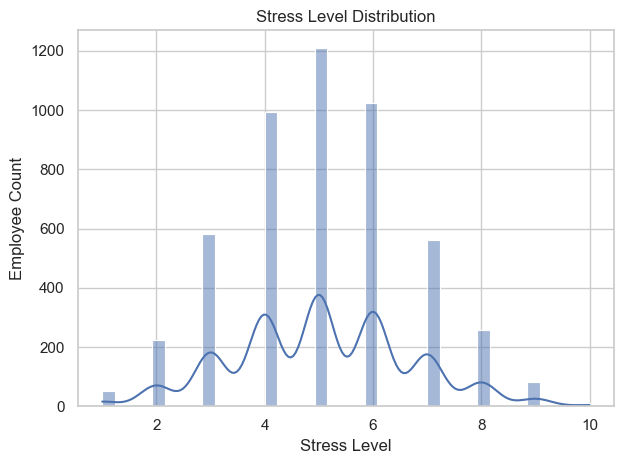

In [26]:
plt.figure()
sns.histplot(wellness_df["stress_level"], kde=True)
plt.title("Stress Level Distribution")
plt.xlabel("Stress Level")
plt.ylabel("Employee Count")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "stress_distribution.png"), dpi=300)
plt.show()


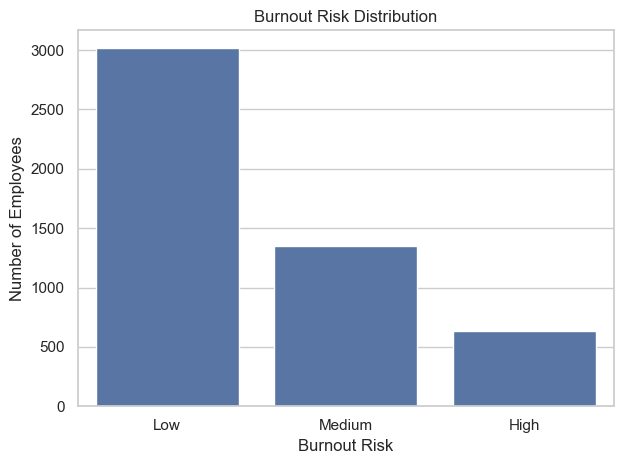

In [25]:
plt.figure()
sns.countplot(x="burnout_risk", data=wellness_df)
plt.title("Burnout Risk Distribution")
plt.xlabel("Burnout Risk")
plt.ylabel("Number of Employees")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "burnout_counts.png"), dpi=300)
plt.show()


## 5. Feature Selection

We will predict **burnout_risk** using wellness-related numeric features.


In [27]:
FEATURES = [
    "work_hours",
    "sleep_hours",
    "stress_level",
    "job_satisfaction",
    "manager_support"
]

TARGET = "burnout_risk"

X = wellness_df[FEATURES]
y = wellness_df[TARGET]

# Drop missing values
model_data = pd.concat([X, y], axis=1).dropna()
X = model_data[FEATURES]
y = model_data[TARGET]

print("Rows used for modeling:", len(X))


Rows used for modeling: 5000


## 6. Encode Target

Convert burnout_risk labels (Low, Medium, High) into numeric values for ML.


In [28]:
label_mapping = {"Low": 0, "Medium": 1, "High": 2}
y_encoded = y.map(label_mapping)

print("Target distribution:")
display(y_encoded.value_counts())


Target distribution:


burnout_risk
0    3015
1    1349
2     636
Name: count, dtype: int64

## 7. Train-Test Split

Split data into training and testing sets.


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Training rows:", len(X_train))
print("Testing rows:", len(X_test))


Training rows: 4000
Testing rows: 1000


## 8. Model Training

We train a RandomForestClassifier for burnout prediction.


In [30]:
burnout_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

burnout_model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


## 9. Model Evaluation

Evaluate performance using:
- Accuracy
- Classification Report
- Confusion Matrix


In [31]:
y_pred = burnout_model.predict(X_test)

print("Model Accuracy:", burnout_model.score(X_test, y_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))


Model Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       603
      Medium       1.00      1.00      1.00       270
        High       1.00      1.00      1.00       127

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



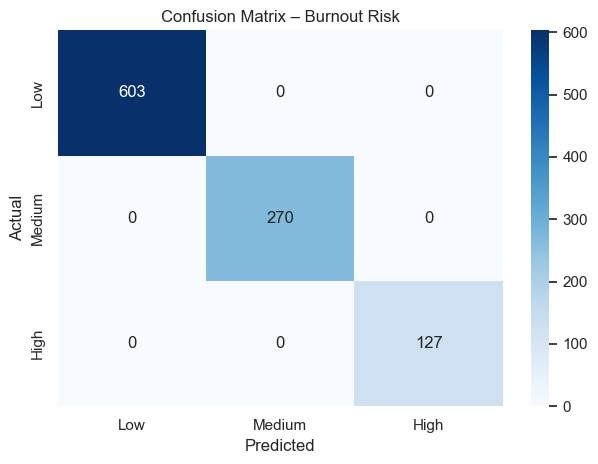

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)
plt.title("Confusion Matrix – Burnout Risk")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "confusion_matrix.png"), dpi=300)
plt.show()


## 10. Feature Importance

Identify which wellness features impact burnout risk the most.


Feature Importance:


stress_level        0.628243
sleep_hours         0.228474
work_hours          0.097073
job_satisfaction    0.044864
manager_support     0.001346
dtype: float64

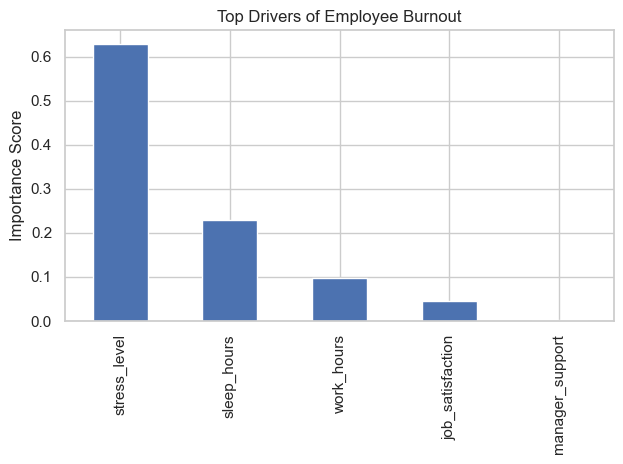

In [33]:
feature_importance = pd.Series(
    burnout_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

print("Feature Importance:")
display(feature_importance)

plt.figure()
feature_importance.plot(kind="bar")
plt.title("Top Drivers of Employee Burnout")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "feature_importance.png"), dpi=300)
plt.show()


## 11. Save Processed Dataset

Save dataset for Power BI dashboard creation.


In [34]:
OUTPUT_PATH = os.path.join(
    PROCESSED_DATA_DIR,
    "employee_wellness_processed.csv"
)

wellness_df.to_csv(OUTPUT_PATH, index=False)
print("Processed data saved to:", OUTPUT_PATH)


Processed data saved to: C:\py_code\Employee\data_processed\employee_wellness_processed.csv
